In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import copy

In [4]:
class L1_Decoder():
    
    
    def distance(self, code1, code2):
        
        distance = 0
        for i in range(len(code1)):
            
            distance += abs(code1[i]-code2[i])
            
        return 0.5*distance
            
    
    def predict(self, EC, code):
        
        distances = []
        
        for code_class in EC:
            
            distances.append(self.distance(code_class, code))

        distances = np.array(distances)
        
        
        return np.argmin(distances)


class L2_Decoder():
    
    
    def distance(self, code1, code2):
        
        distance = 0
        for i in range(len(code1)):
            
            distance += (code1[i]-code2[i]) ** 2
            
        return np.sqrt(distance)
            
    
    def predict(self, EC, code):
        
        distances = []
        
        for code_class in EC:
            
            distances.append(self.distance(code_class, code))

        distances = np.array(distances)
        
        
        return np.argmin(distances)
    
        
class Ecoc():
    
    def __init__(self, EC, classifier,  use_decoding='L2' ):
        
        self.EC = EC
        self.classifier = classifier
        
        if use_decoding == 'L2':  self.decoder  = L2_Decoder()
        if use_decoding == 'L1': self.decoder = L1_Decoder()
        self.classifiers = []
    
    def create_problem(self, X, y, column):
        
        Xcol = []
        ycol = []
        
        for data, label in zip(X, y):
            
            if column[label] == 1:
                
                Xcol.append(data)
                ycol.append(1)
                
            elif column[label] == -1:
                
                Xcol.append(data)
                ycol.append(-1)
            
            else: pass #for this column this class is not considered
        
        return Xcol, ycol
        
    def fit(self, X, y):
        
        if len(self.EC) != len(np.unique(y)): 
            
            print("ECOC matrix bad defined, avorting process")
            
        else:
            
            for column in range(len(self.EC[0])):
                
                Xcolumn, ycolumn = self.create_problem(X, y, self.EC[:, column])
                
                classifier_col = copy.copy(self.classifier)
                
                classifier_col.fit(Xcolumn, ycolumn)
                
                self.classifiers.append(classifier_col)
                
    def predict(self, X, show_code=False):
        
        decoded_codes = []
        for elem in X:
            code = []

            for h in self.classifiers:

                code.append(h.predict(elem.reshape(1,-1))[0])

            if show_code: print("Code for this sample is {}".format(code))
            decoded_code = self.decode(code)
            decoded_codes.append(decoded_code)
            
        return np.array(decoded_codes)
        
        
    def decode(self, code):
        
        pred = self.decoder.predict(self.EC, code)
        
        return pred
    
    def evaluate_accuracy(self, X, y):
        
        yhat = self.predict(X)
        
        errs = (yhat-y).sum()
        
        accuracy = 1 - errs/len(y)
        
        print("Estimated accuracy is {}%".format(accuracy*100))
        
        return accuracy
        

# Toy problem

In [3]:
from sklearn.datasets.samples_generator import make_blobs

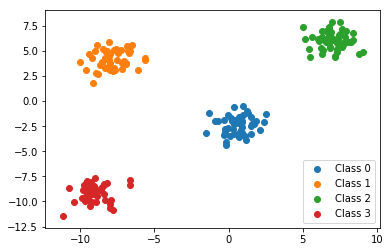

In [6]:
X, y = make_blobs(n_samples=200, centers=4, n_features=2, cluster_std=0.9)


indices0 = np.where(y == 0)
indices1 = np.where(y == 1)
indices2 = np.where(y == 2)
indices3 = np.where(y == 3)

plt.scatter(X[indices0,0], X[indices0,1], label='Class 0')
plt.scatter(X[indices1,0], X[indices1,1], label='Class 1')
plt.scatter(X[indices2,0], X[indices2,1], label='Class 2')
plt.scatter(X[indices3,0], X[indices3,1], label='Class 3')
plt.legend()
plt.show()

In [7]:
ECMatrix = np.array([[1,0,1,-1], [-1,1,0,1], [1,-1,1,1], [0, 1,-1,-1]])
print(ECMatrix)

[[ 1  0  1 -1]
 [-1  1  0  1]
 [ 1 -1  1  1]
 [ 0  1 -1 -1]]


# Using SVM

In [8]:
from sklearn import svm

svm_classifier = svm.SVC()

ECOC_classifier = Ecoc(ECMatrix, svm_classifier)

In [9]:
ECOC_classifier.fit(X, y)

### Example of prediction

Input must be shaped as [nb_samples, n_features].

In [10]:
ECOC_classifier.predict(X[34:45], show_code=True), y[34:45]

Code for this sample is [1, 1, -1, -1]
Code for this sample is [-1, 1, 1, 1]
Code for this sample is [1, -1, 1, 1]
Code for this sample is [1, 1, 1, -1]
Code for this sample is [-1, 1, 1, 1]
Code for this sample is [1, 1, -1, -1]
Code for this sample is [-1, 1, 1, 1]
Code for this sample is [1, 1, -1, -1]
Code for this sample is [1, 1, -1, -1]
Code for this sample is [1, -1, 1, 1]
Code for this sample is [1, 1, 1, -1]


(array([3, 1, 2, 0, 1, 3, 1, 3, 3, 2, 0], dtype=int64),
 array([3, 1, 2, 0, 1, 3, 1, 3, 3, 2, 0]))

# Visualize results

In [17]:
xx,yy = np.meshgrid(np.linspace(-12,11,200),np.linspace(-13,10,200))
viz=np.c_[xx.ravel(),yy.ravel()]

In [18]:
z = ECOC_classifier.predict(viz)

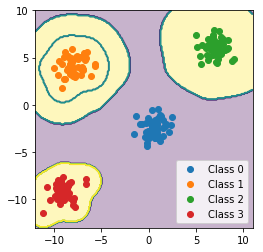

In [19]:
plt.figure()
plt.scatter(X[indices0,0], X[indices0,1], label='Class 0')
plt.scatter(X[indices1,0], X[indices1,1], label='Class 1')
plt.scatter(X[indices2,0], X[indices2,1], label='Class 2')
plt.scatter(X[indices3,0], X[indices3,1], label='Class 3')
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-12,11,-13,10),alpha=0.3, vmin=0, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)))
plt.legend()
plt.show()

In [20]:
ECOC_classifier.evaluate_accuracy(X,y)

Estimated accuracy is 100.0%


1.0

# Using Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()

ECOC_classifier2 = Ecoc(ECMatrix, logReg)

In [22]:
ECOC_classifier2.fit(X, y)

In [23]:
ECOC_classifier2.predict(X[34:45], show_code=True), y[34:45]

Code for this sample is [-1, 1, -1, -1]
Code for this sample is [-1, 1, -1, 1]
Code for this sample is [1, -1, 1, 1]
Code for this sample is [1, -1, 1, -1]
Code for this sample is [-1, 1, -1, 1]
Code for this sample is [-1, 1, -1, -1]
Code for this sample is [-1, 1, -1, 1]
Code for this sample is [-1, 1, -1, -1]
Code for this sample is [-1, 1, -1, -1]
Code for this sample is [1, -1, 1, 1]
Code for this sample is [1, -1, 1, -1]


(array([3, 1, 2, 0, 1, 3, 1, 3, 3, 2, 0], dtype=int64),
 array([3, 1, 2, 0, 1, 3, 1, 3, 3, 2, 0]))

In [24]:
z = ECOC_classifier2.predict(viz)

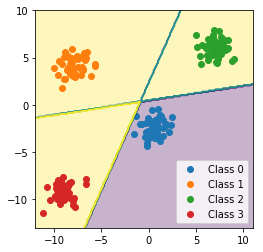

In [25]:
plt.scatter(X[indices0,0], X[indices0,1], label='Class 0')
plt.scatter(X[indices1,0], X[indices1,1], label='Class 1')
plt.scatter(X[indices2,0], X[indices2,1], label='Class 2')
plt.scatter(X[indices3,0], X[indices3,1], label='Class 3')
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-12,11,-13,10),alpha=0.3, vmin=0, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)))
plt.legend()
plt.show()

In [26]:
ECOC_classifier2.evaluate_accuracy(X, y)

Estimated accuracy is 100.0%


1.0